In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

scaler = StandardScaler()

In [3]:
FREDMD = pd.read_excel("FREDMDdata.xlsx")

In [4]:
# number of forecasts 
npred=132

In [5]:
### 데이터 변환에 필요한 함수 목록 ###
def embed(x, dimension=1):
    n, d = x.shape
    if dimension < 1 or dimension > n:
        raise ValueError("Invalid embedding dimension")
    return np.hstack([x[i:n - dimension + i + 1, :] for i in reversed(range(dimension))])

def normalize_columns(df):
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [6]:
### Lasso CV 함수 예시
def run_shrinkage_cv(Y, horizon, alpha=1.0):
    Y2 = Y.copy()
    pca = PCA(n_components=4)
    scores = pca.fit_transform((Y2 - Y2.mean()).to_numpy())
    Y2 = pd.concat([Y2, pd.DataFrame(scores, index=Y2.index)], axis=1)
    Y2.columns = Y2.columns.astype(str)
    Y3 = normalize_columns(Y2).to_numpy()

    aux = embed(Y3, 4)

    Xin = aux[:-horizon]
    Xout = aux[-1]

    y = Y2.iloc[-Xin.shape[0]:, 0]
    X = Xin
    X_out = Xout

    if alpha==0.0: 
        n_lambdas = 100
        lambda_grid = np.exp(np.linspace(np.log(100.0), np.log(0.000001), n_lambdas))
        model = ElasticNetCV(l1_ratio=alpha, alphas=lambda_grid,fit_intercept=True).fit(X, y)
    else :
        model = ElasticNetCV(l1_ratio=alpha, n_alphas=100, fit_intercept=True).fit(X, y)

    pred = model.predict(X_out.reshape(1, -1))
    return model, pred
    
def shrinkage_cv_rolling_window(Y, npred, horizon, alpha=1.0):
    save_model = []
    save_pred = []

    for i in range(npred, horizon - 1, -1):
        Y_window = Y.iloc[(npred - i):(len(Y) - i), :]
        model, pred = run_shrinkage_cv(Y_window, horizon, alpha)
        save_model.append(model)
        save_pred.append(pred[0])
        print(f"lasso_iter {npred - i} horizon {horizon}", end='\r', flush=True)

    real = Y.values[:, 0]
    pred_series = np.concatenate([np.full(len(real) - len(save_pred), np.nan), save_pred])

    rmse = np.sqrt(mean_squared_error(real[-len(save_pred):], save_pred))
    mae = mean_absolute_error(real[-len(save_pred):], save_pred)

    # Plot
    plt.plot(real, label="Actual")
    padding = [np.nan] * (len(real) - len(pred_series))
    plt.plot(padding + list(pred_series), label="Forecast", color="red")
    plt.legend()
    plt.title("Rolling Window Forecast")
    plt.show()

    return {
        "pred": save_pred,
        "errors": {"rmse": rmse, "mae": mae},
        "model" : save_model}

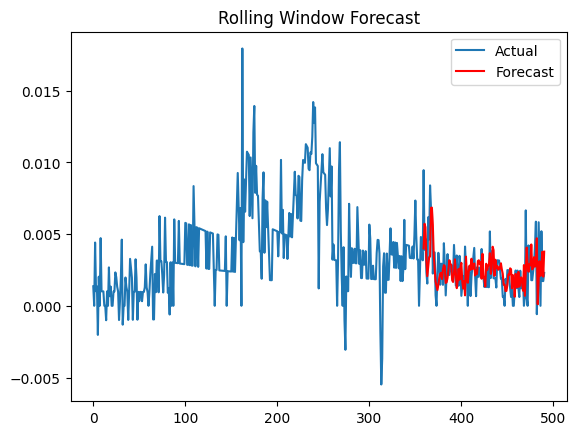

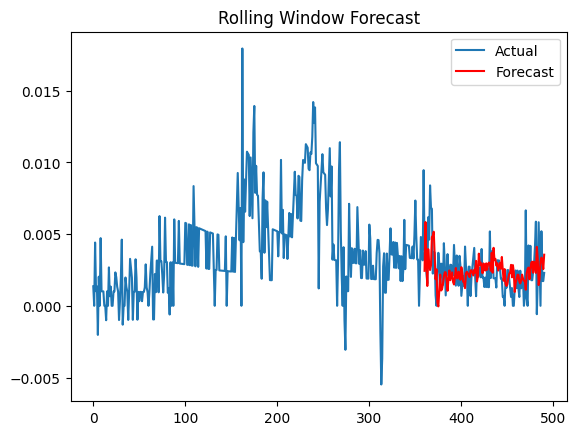

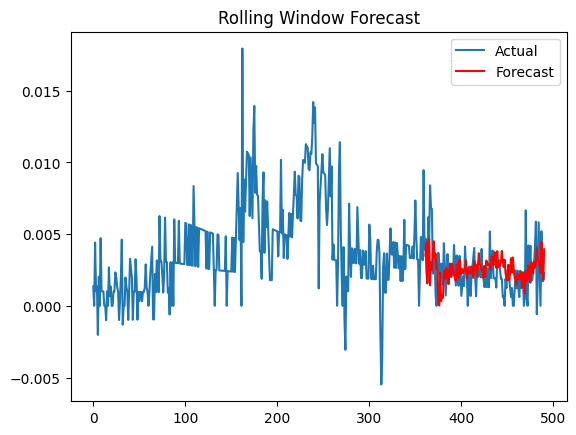

In [7]:
## LASSO cross-validation 예시 ##
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
## 경고 문구가 과도하게 뜨는 것을 방지하기 위한 코드

lasso_1 = shrinkage_cv_rolling_window(Y = FREDMD, npred = npred, horizon = 1, alpha = 1.0)
lasso_2 = shrinkage_cv_rolling_window(Y = FREDMD, npred = npred, horizon = 2, alpha = 1.0)
lasso_3 = shrinkage_cv_rolling_window(Y = FREDMD, npred = npred, horizon = 3, alpha = 1.0)